## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [1]:
!pip install -qq torch torchvision

In [2]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16
Unpacking objects: 100% (19/19), done.


## Task 2 : Loading VGG Pretrained Model

In [7]:
import torch
from torchvision import models

In [8]:
vgg = models.vgg19(weights='VGG19_Weights.DEFAULT')
vgg = vgg.features

In [9]:
for parameters in vgg.parameters():
    parameters.requires_grad_(False)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
vgg.to(device);

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [17]:
from PIL import Image
from torchvision import transforms as T

In [18]:
def preprocess(img_path, max_size=512):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = img_transforms(image)
    image = image.unsqueeze(0)

    return image

In [20]:
content_p = preprocess('/content/Project-NST/content11.jpg').to(device)
style_p = preprocess('/content/Project-NST/style12.jpg').to(device)

print(f'Content shape: {content_p.shape}')
print(f'Style shape: {style_p.shape}')

Content shape: torch.Size([1, 3, 259, 345])
Style shape: torch.Size([1, 3, 640, 512])


## Task 4 : Deprocess image

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def deprocess(tensor):
    image = tensor.to('cpu').detach().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.asarray([0.229, 0.224, 0.225]) + np.asarray([0.485, 0.456, 0.406])
    image = image.clip(0, 1)

    return image

In [23]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print(f'Content shape: {content_d.shape}')
print(f'Style shape: {style_d.shape}')

Content shape: (259, 345, 3)
Style shape: (640, 512, 3)


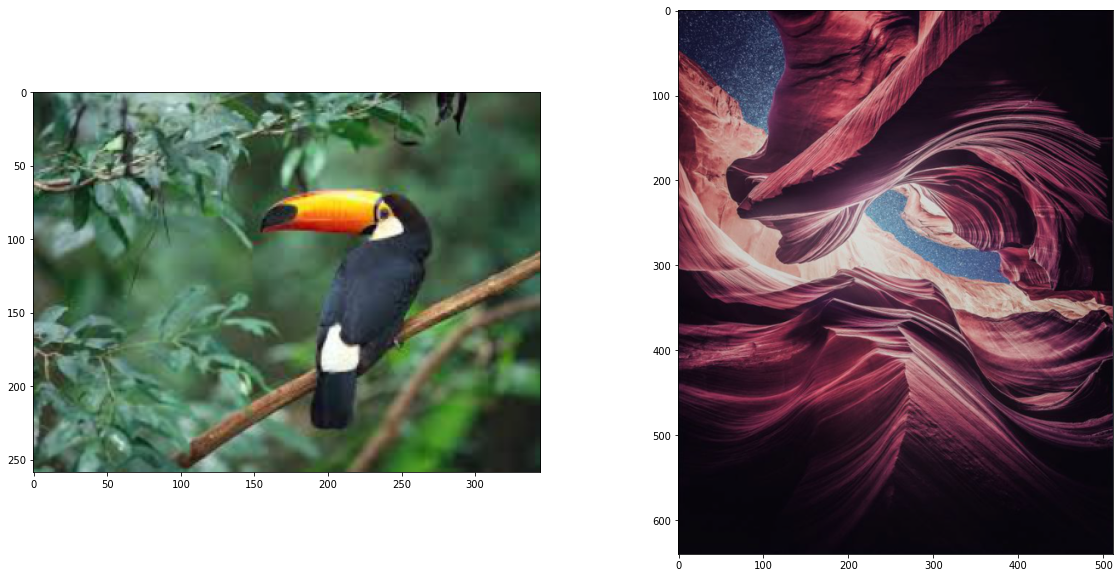

In [26]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content_d);
ax2.imshow(style_d);

## Task 5 : Get content,style features and create gram matrix

In [29]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2', # content features
        '28': 'conv5_1',
    }

    x = image
    features = {}
    for name, layer in model._modules.items():
        x = layer(x)

        if name in layers:
            features[layers[name]] = x

    return features


In [30]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

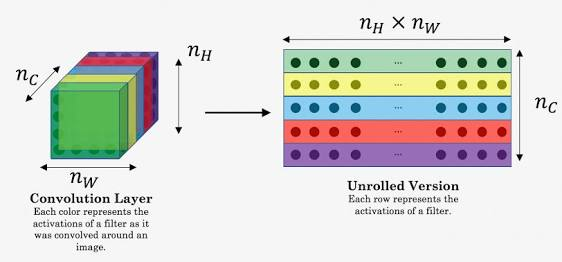

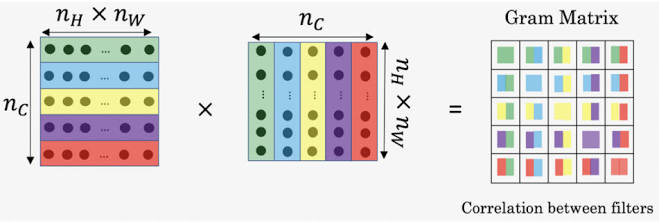

In [31]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [37]:
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [34]:
def content_loss(target_conv4_2, content_conv4_2):
    loss = torch.mean((target_conv4_2 - content_conv4_2) ** 2)
    return loss

In [35]:
style_weight = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,
}

In [36]:
def style_loss(style_weight, target_features, style_grams):
    loss = 0
    for layer in style_weight:
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        style_gram = style_grams[layer]

        b, c, w, h = target_f.shape
        layer_loss = style_weight[layer] * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss / (c * w * h)
    return loss

In [38]:
target = content_p.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)

print(f"Content loss: {content_loss(target_f['conv4_2'], content_f['conv4_2'])}")
print(f"Style loss: {style_loss(style_weight, target_f, style_grams)}")

Content loss: 0.0
Style loss: 1980.387939453125


## Task 7 : Training loop

In [47]:
from torch import optim
from tqdm import trange

In [48]:
optimizer = optim.Adam([target], lr=3e-3)

In [49]:
alpha = 1
beta = 1e5
epochs = 3000
show_every_steps = 500

In [50]:
def total_loss(c_loss, s_loss, alpha, beta):
    return alpha * c_loss + beta * s_loss

In [52]:
results = []

pbar = trange(epochs, desc='Training loop', unit="epochs")
for i in pbar:
    target_f = get_features(target, vgg)
    c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
    s_loss = style_loss(style_weight, target_f, style_grams)
    t_loss = total_loss(c_loss, s_loss, alpha, beta)

    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()

    if i % show_every_steps == 0:
        pbar.set_postfix(divisors={'Total loss': t_loss.item(), 'Content loss': s_loss.item(), 'Style loss': c_loss.item()})
        results.append(deprocess(target.detach()))

Training loop: 100%|██████████| 3000/3000 [01:38<00:00, 30.36epochs/s, divisors={'Total loss': 9526185.0, 'Content loss': 95.26170349121094, 'Style loss': 15.454750061035156}]


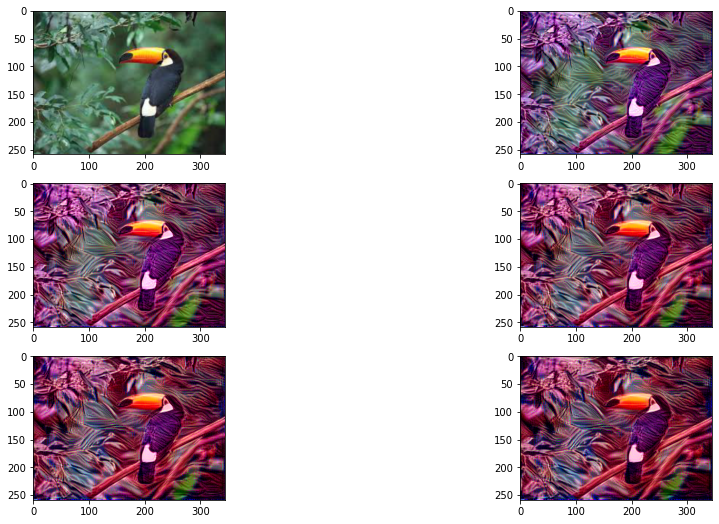

In [53]:
plt.figure(figsize=(16, 9))

for i in range(len(results)):
    plt.subplot(3, 2, i+1)
    plt.imshow(results[i])
plt.show()

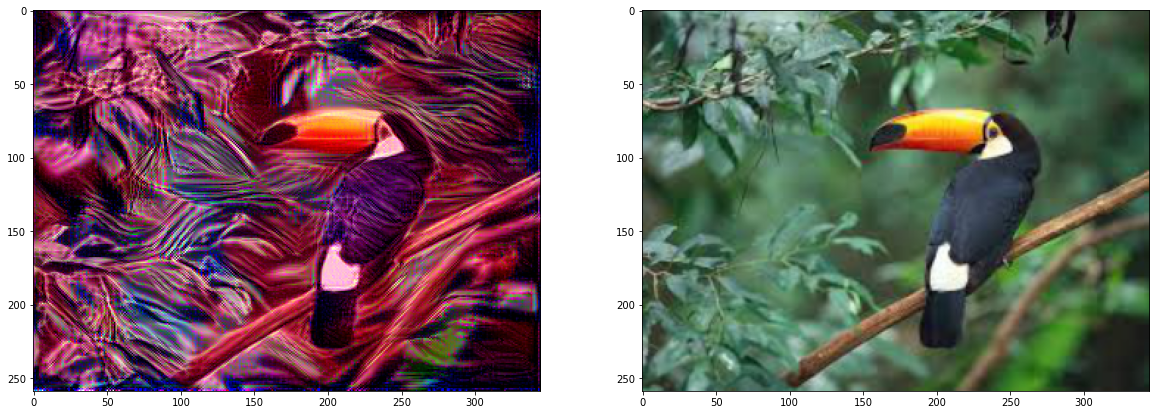

In [54]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(deprocess(target.detach()));
ax2.imshow(deprocess(content_p));